In [2]:
from torchvision.datasets.utils import download_url 

In [3]:
url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(url, './cifar10data')

Using downloaded and verified file: ./cifar10data\cifar10.tgz


In [4]:
import tarfile

In [5]:
# path_drive = './cifar10data/cifar10.tgz'
# with tarfile.open(path_drive, 'r:gz') as t:
#     t.extractall('./cifar10data')

In [6]:
import os

In [7]:
path = './cifar10data/cifar10'
print(os.listdir(path))

['test', 'train']


In [8]:
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder

In [9]:
train_path = path + '/train'
test_path = path + '/test'

train_data = ImageFolder(train_path, transform= ToTensor())
test_ds = ImageFolder(test_path, transform= ToTensor())

In [10]:
from torch.utils.data import random_split

In [11]:
train_ds, _ = random_split(train_data, [50000,0])

In [12]:
from torch.utils.data import DataLoader

In [13]:
train_dl = DataLoader(train_ds, 100)

In [1]:
import torch.nn as nn
import torch

In [2]:
class resnet12(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv3t12 = nn.Conv2d(3,12, kernel_size=3, stride=1, padding=1)
        
        self.conv12t48 = nn.Conv2d(12,48, kernel_size=3, stride=1, padding=1)
        
        self.conv48t96 = nn.Conv2d(48,96, kernel_size=3, stride=1, padding=1)
        self.conv96t96a = nn.Conv2d(96,96, kernel_size=3, stride=1, padding=1)
        
        self.conv96t192 = nn.Conv2d(96,192, kernel_size=3, stride=1, padding=1)
        self.conv192t192a = nn.Conv2d(192,192, kernel_size=3, stride=1, padding=1)
        self.conv192t192b = nn.Conv2d(192,192, kernel_size=3, stride=1, padding=1)
        self.conv192t192c = nn.Conv2d(192,192, kernel_size=3, stride=1, padding=1)
        
        self.conv192t384 = nn.Conv2d(192,384,kernel_size=3,stride=1, padding=1)
        self.conv384t384a = nn.Conv2d(384,384, kernel_size=3, stride=1, padding=1)
        self.conv384t384b = nn.Conv2d(384,384, kernel_size=3, stride=1, padding=1)
        self.conv384t384c = nn.Conv2d(384,384, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.norm12 = nn.BatchNorm2d(12)
        self.norm48 = nn.BatchNorm2d(48)
        self.norm96 = nn.BatchNorm2d(96)
        self.norm192 = nn.BatchNorm2d(192)
        self.norm384 = nn.BatchNorm2d(384)
        
        self.relu = nn.ReLU()
        
        self.adpool = nn.AdaptiveAvgPool2d(1) 
        
        self.drop = nn.Dropout(0.2)
                                         
        self.linear = nn.Linear(384, 10)
        
        self.flat = nn.Flatten()
        
    
    def forward(self,x):
        out = self.conv3t12(x) # 32x 32  12
        out = self.norm12(out)
        out = self.relu(out)
        out = self.conv12t48(out) # 32 x32  48
        out = self.norm48(out)
        out = self.relu(out)
        out = self.pool(out) #16x16  48
        
        out = self.conv48t96(out)  # 16x 16 96
        out = self.norm96(out)
        y = out
        out = self.relu(out)
        out = self.conv96t96a(out) # 16x 16 96
        out = self.norm96(out)
        out= self.relu(out+y)
        out = self.pool(out) # 8x8 96
        
        out = self.conv96t192(out) # 8x8 192
        out = self.norm192(out)
        y = out
        out = self.relu(out)
        out = self.conv192t192a(out)
        out = self.norm192(out)
        out = self.relu(out+y)
        out = self.conv192t192b(out)
        out = self.norm192(out)
        out = self.relu(out+y)
        out = self.conv192t192c(out)
        out = self.norm192(out)
        out = self.relu(out+y)
        
        out = self.conv192t384(out)
        out = self.norm384(out)
        y = out
        out = self.relu(out)
        out = self.conv384t384a(out)
        out = self.norm384(out)
        out = self.relu(out+y)
        out = self.conv384t384b(out)
        out = self.norm384(out)
        out = self.relu(out+y)
        out = self.conv384t384c(out)
        out = self.norm384(out)
        out = self.relu(out)
        
        
        out = self.adpool(out)
        out = self.flat(out)
        out = self.drop(out)
        out = self.linear(out)
        out = torch.softmax(out, dim=-1)
        
        return out
    
model = resnet12()
for i,_ in train_dl:
    print(i.shape)
    out = model(i)
    print(out.shape)
    break
        

NameError: name 'train_dl' is not defined

In [16]:
import torch

In [28]:
loss_func = nn.BCELoss()
opt_func = torch.optim.Adam(model.parameters(), lr=3e-2)


In [19]:
import numpy as np

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
num_epochs = 150
model = model.to(device)
def fit(num_epochs):
    for epoch in range(num_epochs):
        for img, labels in train_dl:
            hot_result = []
            for label in labels:
                z = np.zeros(10)
                z[int(label)] = 1
                hot_result.append(z.astype(np.float32))
            
            img = img.to(device)
            pred = model(img)
            hot_result = torch.tensor(hot_result)
            hot_result = hot_result.to(device)
            loss = loss_func(pred, hot_result)
            loss.backward()
            opt_func.step()
            opt_func.zero_grad()
        pred_arr = torch.argmax(pred, 1)
        result_arr = torch.argmax(hot_result, 1)
        accuracy = torch.sum(pred_arr == result_arr).item()/len(pred_arr)
        print(f'Accuracy: {accuracy*100}%, epoch: {epoch+1}, loss: {loss}, device: {device}')
        if accuracy >= 0.9:
            break

In [22]:
torch.save(model.state_dict(), 'Cifar10Cnn.pth')

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:

new_model = Cifar10Model()
new_model.load_state_dict(torch.load(r'savedmodels\Cifar10Cnn.pth'))

NameError: name 'Cifar10Model' is not defined

In [ ]:
import cv2

In [ ]:
def pred(path):
    q = path
    img = cv2.imread(q, 1)
    plt.imshow(img)
    img = cv2.resize(img, (32,32))
    img_arr = np.asarray(img).astype(np.float32)
    img_tensor = torch.Tensor(img_arr)
    img_tensor = img_tensor/255
    img_tensor = img_tensor.permute(2,0,1)
    img_tensor = img_tensor.unsqueeze(0)
    pred = new_model(img_tensor)
    _,pred = torch.max(pred, dim=1)
    print(train_data.classes[pred[0].item()])

dog


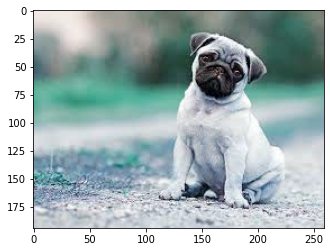

In [ ]:
pred(r'C:\Users\user\Downloads\doberman.jfif')

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cpu')

In [ ]:
import numpy as np
num_epochs = 1
# loss_func = F.cross_entropy()
optim = torch.optim.Adam(model.parameters(), lr=3e-3)

for epoch in range(num_epochs):
    
    res = []
    for i,l in train_dl:
        for _ in l:
            z = np.zeros(10)
            z[int(_)] = 1
            res.append(z.astype(np.float32))
        i = i.to(device)
        pred = model(i)
        res = torch.tensor(res)
        res = res.to(device)
        loss = loss_func(pred, res)
        loss.backward()
        opt_func.step()
        opt_func.zero_grad()
    with torch.no_grad():
        acc_res=[]
        for i,l in test_dl:
            for _ in l:
                z = np.zeros(10)
                z[int(_)] = 1
                acc_res.append(z.astype(np.float32))
            i = i.to(device)
            pred_ = model(i)
        pred_arr = torch.argmax(pred_, 1)
        result_arr= torch.argmax(res, 1)
        accuracy = torch.sum(pred_arr == result_arr).item()/len(pred_arr)
    print(f'Accuracy: {accuracy}, epoch: {epoch}, loss: {loss}, device: {device}')
            
        
    

In [32]:
pred_arr = torch.argmax(pred, 1)
    result_arr= torch.argmax(res, 1)
    accuracy = torch.sum(pred_arr == result_arr).item()/len(pred_arr)
    print(f'Accuracy: {accuracy}, epoch: {epoch}, loss: {loss}')
        

res = []
for i,l in train_dl:
    for _ in l:
        z = np.zeros(10)
        z[int(_)] = 1
        res.append(z.astype(np.float32))
        break
res = torch.tensor(res)
print(res)
result_arr = torch.argmax(res, 1)
result_arr

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


tensor([3, 9, 9, 0, 2, 6, 7, 3, 0, 0, 4, 1, 9, 3, 4, 4, 9, 9, 5, 7, 8, 9, 0, 3,
        6, 6, 0, 9, 5, 9, 2, 9, 5, 2, 7, 9, 5, 1, 1, 7, 9, 6, 4, 0, 1, 2, 0, 5,
        8, 9, 7, 3, 9, 3, 0, 5, 8, 6, 4, 9, 7, 8, 6, 6, 5, 1, 6, 0, 3, 2, 2, 5,
        8, 5, 7, 9, 1, 6, 1, 0, 6, 4, 9, 7, 8, 7, 3, 6, 4, 4, 7, 9, 2, 7, 1, 9,
        4, 7, 1, 9, 9, 9, 7, 5, 0, 5, 0, 3, 8, 7, 9, 8, 6, 9, 4, 6, 9, 5, 1, 7,
        0, 7, 8, 7, 2, 8, 3, 6, 0, 3, 8, 3, 9, 6, 5, 7, 1, 3, 2, 6, 6, 1, 6, 8,
        7, 7, 0, 1, 3, 5, 3, 9, 0, 2, 8, 4, 2, 7, 0, 0, 2, 6, 4, 0, 6, 4, 3, 9,
        0, 8, 9, 5, 0, 2, 4, 1, 1, 6, 5, 6, 0, 7, 4, 9, 8, 6, 2, 4, 3, 8, 6, 2,
        6, 6, 2, 4, 9, 3, 3, 6, 6, 3, 3, 1, 9, 7, 9, 5, 8, 7, 6, 7, 1, 6, 3, 4,
        8, 3, 4, 2, 9, 3, 8, 1, 8, 8, 9, 1, 9, 5, 5, 8, 4, 9, 7, 4, 4, 7, 9, 4,
        5, 6, 4, 2, 9, 1, 0, 1, 4, 1, 8, 6, 3, 5, 2, 9, 5, 0, 6, 3, 9, 2, 9, 5,
        1, 5, 4, 8, 3, 6, 8, 8, 7, 5, 9, 7, 3, 0, 2, 2, 5, 8, 5, 8, 2, 3, 3, 4,
        9, 0, 2, 3, 3, 1, 1, 9, 1, 8, 0,

In [ ]:
with torch.no_grad():
            x = 0
            for i,l in test_dl:
                i = i.to(device)
                preds_ = model(i)

                for j in range(len(preds_)):
                    if preds_[j].max()==preds_[j][l[j].item()]:
                        x += 1
            
            accuracy = x/len(test_ds)
            print(f'{accuracy}, {epoch}')
            print("")

In [ ]:
with torch.no_grad():
        for i,l in test_dl:
            i = i.to(device)
            l = l.to(device)
            pred_ = model(i)
        _,pred_arr = torch.max(pred_, 1)
        accuracy = torch.sum(pred_arr == l).item()/len(test_dl)
        print(f'Accuracy: {accuracy*100}, epoch: {epoch+1}')